In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 10

In [6]:


def build_encoder():
    # Encoder

    img = Input(shape=img_shape)

    h = Flatten()(img)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    mu = Dense(latent_dim)(h)
    log_var = Dense(latent_dim)(h)
    latent_repr = merge([mu, log_var],
            mode=lambda p: p[0] + K.random_normal(K.shape(p[0])) * K.exp(p[1] / 2),
            output_shape=lambda p: p[0])

    return Model(img, latent_repr)

In [7]:
def build_decoder():

    model = Sequential()

    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    z = Input(shape=(latent_dim,))
    img = model(z)

    return Model(z, img)

In [8]:
def build_discriminator():

    model = Sequential()

    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.summary()

    encoded_repr = Input(shape=(latent_dim, ))
    validity = model(encoded_repr)

    return Model(encoded_repr, validity)

In [10]:
def train(epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        latent_fake = encoder.predict(imgs)
        latent_real = np.random.normal(size=(batch_size, latent_dim))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(latent_real, valid)
        d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator
        g_loss = adversarial_autoencoder.train_on_batch(imgs, [imgs, valid])

        # Plot the progress
        print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch)

In [12]:
def sample_images(epoch):
    r, c = 5, 5

    z = np.random.normal(size=(r*c, latent_dim))
    gen_imgs = decoder.predict(z)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [16]:
def save_model():

    def save(model, model_name):
        model_path = "saved_model/%s.json" % model_name
        weights_path = "saved_model/%s_weights.hdf5" % model_name
        options = {"file_arch": model_path,
                    "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])

    save(generator, "aae_generator")
    save(discriminator, "aae_discriminator")


In [17]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

# Build the encoder / decoder
encoder = build_encoder()
decoder = build_decoder()

img = Input(shape=img_shape)
# The generator takes the image, encodes it and reconstructs it
# from the encoding
encoded_repr = encoder(img)
reconstructed_img = decoder(encoded_repr)

# For the adversarial_autoencoder model we will only train the generator
discriminator.trainable = False

# The discriminator determines validity of the encoding
validity = discriminator(encoded_repr)

# The adversarial_autoencoder model  (stacked generator and discriminator)
adversarial_autoencoder = Model(img, [reconstructed_img, validity])
adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'],
    loss_weights=[0.999, 0.001],
    optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               5632      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 137,217
Trainable params: 137,217
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [19]:
import os
os.mkdir('images')

In [24]:
train(epochs=2000, batch_size=32, sample_interval=200)

/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.117071, acc: 100.00%] [G loss: 0.138189, mse: 0.133055]
1 [D loss: 0.129137, acc: 98.44%] [G loss: 0.120724, mse: 0.115020]
2 [D loss: 0.111143, acc: 100.00%] [G loss: 0.148766, mse: 0.143413]
3 [D loss: 0.097036, acc: 100.00%] [G loss: 0.127572, mse: 0.122066]
4 [D loss: 0.124089, acc: 98.44%] [G loss: 0.139626, mse: 0.133977]
5 [D loss: 0.098225, acc: 100.00%] [G loss: 0.116601, mse: 0.110718]
6 [D loss: 0.089921, acc: 100.00%] [G loss: 0.112421, mse: 0.106220]
7 [D loss: 0.104879, acc: 96.88%] [G loss: 0.121638, mse: 0.116032]
8 [D loss: 0.098884, acc: 100.00%] [G loss: 0.115424, mse: 0.109936]
9 [D loss: 0.106031, acc: 98.44%] [G loss: 0.126131, mse: 0.120816]
10 [D loss: 0.080312, acc: 100.00%] [G loss: 0.127893, mse: 0.122672]
11 [D loss: 0.115592, acc: 98.44%] [G loss: 0.129586, mse: 0.124615]
12 [D loss: 0.096763, acc: 100.00%] [G loss: 0.128647, mse: 0.122738]
13 [D loss: 0.083225, acc: 98.44%] [G loss: 0.126515, mse: 0.121015]
14 [D loss: 0.122723, acc: 96.88%] [

119 [D loss: 0.035620, acc: 100.00%] [G loss: 0.106430, mse: 0.100655]
120 [D loss: 0.024151, acc: 100.00%] [G loss: 0.114146, mse: 0.107397]
121 [D loss: 0.038146, acc: 100.00%] [G loss: 0.126404, mse: 0.120387]
122 [D loss: 0.030314, acc: 100.00%] [G loss: 0.118085, mse: 0.112201]
123 [D loss: 0.028352, acc: 100.00%] [G loss: 0.118388, mse: 0.112457]
124 [D loss: 0.035183, acc: 100.00%] [G loss: 0.120880, mse: 0.114293]
125 [D loss: 0.022502, acc: 100.00%] [G loss: 0.114251, mse: 0.107760]
126 [D loss: 0.021901, acc: 100.00%] [G loss: 0.116254, mse: 0.109848]
127 [D loss: 0.034199, acc: 100.00%] [G loss: 0.127130, mse: 0.120943]
128 [D loss: 0.023566, acc: 100.00%] [G loss: 0.117424, mse: 0.111747]
129 [D loss: 0.034576, acc: 100.00%] [G loss: 0.122343, mse: 0.116051]
130 [D loss: 0.033011, acc: 100.00%] [G loss: 0.101832, mse: 0.095950]
131 [D loss: 0.020653, acc: 100.00%] [G loss: 0.123466, mse: 0.117703]
132 [D loss: 0.023175, acc: 100.00%] [G loss: 0.102913, mse: 0.096918]
133 [D

240 [D loss: 0.032217, acc: 100.00%] [G loss: 0.111292, mse: 0.104731]
241 [D loss: 0.015639, acc: 100.00%] [G loss: 0.125168, mse: 0.118112]
242 [D loss: 0.022971, acc: 100.00%] [G loss: 0.116407, mse: 0.109108]
243 [D loss: 0.025173, acc: 100.00%] [G loss: 0.114588, mse: 0.107441]
244 [D loss: 0.020269, acc: 100.00%] [G loss: 0.110084, mse: 0.103341]
245 [D loss: 0.012679, acc: 100.00%] [G loss: 0.114965, mse: 0.107979]
246 [D loss: 0.047325, acc: 98.44%] [G loss: 0.115894, mse: 0.109031]
247 [D loss: 0.013496, acc: 100.00%] [G loss: 0.109020, mse: 0.101744]
248 [D loss: 0.016133, acc: 100.00%] [G loss: 0.106835, mse: 0.099926]
249 [D loss: 0.020046, acc: 100.00%] [G loss: 0.107996, mse: 0.101252]
250 [D loss: 0.019286, acc: 100.00%] [G loss: 0.122976, mse: 0.116801]
251 [D loss: 0.016036, acc: 100.00%] [G loss: 0.104918, mse: 0.098212]
252 [D loss: 0.015848, acc: 100.00%] [G loss: 0.122854, mse: 0.116454]
253 [D loss: 0.019800, acc: 100.00%] [G loss: 0.110094, mse: 0.103698]
254 [D 

367 [D loss: 0.029319, acc: 100.00%] [G loss: 0.105397, mse: 0.098987]
368 [D loss: 0.014886, acc: 100.00%] [G loss: 0.128570, mse: 0.121526]
369 [D loss: 0.034943, acc: 98.44%] [G loss: 0.093809, mse: 0.087030]
370 [D loss: 0.016760, acc: 100.00%] [G loss: 0.106872, mse: 0.099406]
371 [D loss: 0.022250, acc: 100.00%] [G loss: 0.121704, mse: 0.113586]
372 [D loss: 0.017127, acc: 100.00%] [G loss: 0.113422, mse: 0.106006]
373 [D loss: 0.026751, acc: 98.44%] [G loss: 0.120064, mse: 0.113139]
374 [D loss: 0.025204, acc: 100.00%] [G loss: 0.117088, mse: 0.109708]
375 [D loss: 0.023778, acc: 100.00%] [G loss: 0.118575, mse: 0.112348]
376 [D loss: 0.035421, acc: 98.44%] [G loss: 0.107859, mse: 0.100810]
377 [D loss: 0.016449, acc: 100.00%] [G loss: 0.109608, mse: 0.102175]
378 [D loss: 0.014227, acc: 100.00%] [G loss: 0.112953, mse: 0.105611]
379 [D loss: 0.012917, acc: 100.00%] [G loss: 0.110173, mse: 0.103095]
380 [D loss: 0.018720, acc: 100.00%] [G loss: 0.123841, mse: 0.117223]
381 [D lo

488 [D loss: 0.034521, acc: 100.00%] [G loss: 0.099896, mse: 0.092957]
489 [D loss: 0.079633, acc: 98.44%] [G loss: 0.116926, mse: 0.111574]
490 [D loss: 0.043643, acc: 98.44%] [G loss: 0.097785, mse: 0.091007]
491 [D loss: 0.031370, acc: 100.00%] [G loss: 0.110682, mse: 0.104040]
492 [D loss: 0.076523, acc: 98.44%] [G loss: 0.109830, mse: 0.102958]
493 [D loss: 0.025895, acc: 100.00%] [G loss: 0.116781, mse: 0.109573]
494 [D loss: 0.028380, acc: 100.00%] [G loss: 0.116780, mse: 0.108202]
495 [D loss: 0.046315, acc: 98.44%] [G loss: 0.120449, mse: 0.113962]
496 [D loss: 0.058551, acc: 96.88%] [G loss: 0.105684, mse: 0.099991]
497 [D loss: 0.040884, acc: 100.00%] [G loss: 0.096760, mse: 0.090942]
498 [D loss: 0.026466, acc: 100.00%] [G loss: 0.114727, mse: 0.108538]
499 [D loss: 0.044720, acc: 100.00%] [G loss: 0.113407, mse: 0.107106]
500 [D loss: 0.012412, acc: 100.00%] [G loss: 0.104809, mse: 0.097411]
501 [D loss: 0.024818, acc: 100.00%] [G loss: 0.108843, mse: 0.103314]
502 [D loss

614 [D loss: 0.176282, acc: 92.19%] [G loss: 0.113627, mse: 0.107708]
615 [D loss: 0.125268, acc: 92.19%] [G loss: 0.113897, mse: 0.107633]
616 [D loss: 0.098648, acc: 93.75%] [G loss: 0.112648, mse: 0.106727]
617 [D loss: 0.077363, acc: 96.88%] [G loss: 0.103186, mse: 0.096355]
618 [D loss: 0.117898, acc: 96.88%] [G loss: 0.104464, mse: 0.097382]
619 [D loss: 0.084560, acc: 96.88%] [G loss: 0.108285, mse: 0.102787]
620 [D loss: 0.075497, acc: 96.88%] [G loss: 0.105919, mse: 0.099640]
621 [D loss: 0.133107, acc: 93.75%] [G loss: 0.115627, mse: 0.110055]
622 [D loss: 0.098145, acc: 93.75%] [G loss: 0.096542, mse: 0.091100]
623 [D loss: 0.054787, acc: 100.00%] [G loss: 0.105015, mse: 0.099305]
624 [D loss: 0.071378, acc: 96.88%] [G loss: 0.107667, mse: 0.100284]
625 [D loss: 0.063585, acc: 96.88%] [G loss: 0.095166, mse: 0.088174]
626 [D loss: 0.137040, acc: 95.31%] [G loss: 0.098748, mse: 0.092967]
627 [D loss: 0.046873, acc: 98.44%] [G loss: 0.094538, mse: 0.088770]
628 [D loss: 0.0979

735 [D loss: 0.209116, acc: 90.62%] [G loss: 0.102375, mse: 0.097598]
736 [D loss: 0.174985, acc: 93.75%] [G loss: 0.123719, mse: 0.118592]
737 [D loss: 0.147998, acc: 95.31%] [G loss: 0.098548, mse: 0.093060]
738 [D loss: 0.092379, acc: 95.31%] [G loss: 0.104553, mse: 0.098365]
739 [D loss: 0.149577, acc: 93.75%] [G loss: 0.098360, mse: 0.093844]
740 [D loss: 0.124690, acc: 93.75%] [G loss: 0.116433, mse: 0.110737]
741 [D loss: 0.122831, acc: 93.75%] [G loss: 0.082081, mse: 0.074968]
742 [D loss: 0.143867, acc: 96.88%] [G loss: 0.104864, mse: 0.100015]
743 [D loss: 0.236843, acc: 90.62%] [G loss: 0.105727, mse: 0.100076]
744 [D loss: 0.070863, acc: 100.00%] [G loss: 0.113012, mse: 0.107523]
745 [D loss: 0.185381, acc: 93.75%] [G loss: 0.111173, mse: 0.106231]
746 [D loss: 0.136543, acc: 93.75%] [G loss: 0.100956, mse: 0.095600]
747 [D loss: 0.220387, acc: 87.50%] [G loss: 0.102157, mse: 0.097237]
748 [D loss: 0.119562, acc: 95.31%] [G loss: 0.104982, mse: 0.099042]
749 [D loss: 0.1337

864 [D loss: 0.232186, acc: 90.62%] [G loss: 0.097079, mse: 0.092502]
865 [D loss: 0.234583, acc: 89.06%] [G loss: 0.094273, mse: 0.090427]
866 [D loss: 0.173587, acc: 90.62%] [G loss: 0.095055, mse: 0.090464]
867 [D loss: 0.122220, acc: 96.88%] [G loss: 0.103160, mse: 0.098904]
868 [D loss: 0.116332, acc: 93.75%] [G loss: 0.086787, mse: 0.081954]
869 [D loss: 0.187850, acc: 95.31%] [G loss: 0.094559, mse: 0.090759]
870 [D loss: 0.271028, acc: 92.19%] [G loss: 0.109501, mse: 0.105565]
871 [D loss: 0.219747, acc: 89.06%] [G loss: 0.105876, mse: 0.100833]
872 [D loss: 0.166411, acc: 93.75%] [G loss: 0.103954, mse: 0.099518]
873 [D loss: 0.308824, acc: 87.50%] [G loss: 0.100096, mse: 0.096467]
874 [D loss: 0.171190, acc: 93.75%] [G loss: 0.096718, mse: 0.092083]
875 [D loss: 0.245641, acc: 92.19%] [G loss: 0.091235, mse: 0.088020]
876 [D loss: 0.154566, acc: 92.19%] [G loss: 0.099491, mse: 0.095664]
877 [D loss: 0.161263, acc: 92.19%] [G loss: 0.087635, mse: 0.083789]
878 [D loss: 0.20958

989 [D loss: 0.216002, acc: 92.19%] [G loss: 0.105650, mse: 0.102304]
990 [D loss: 0.256957, acc: 90.62%] [G loss: 0.098742, mse: 0.094651]
991 [D loss: 0.284874, acc: 90.62%] [G loss: 0.102336, mse: 0.098342]
992 [D loss: 0.385967, acc: 81.25%] [G loss: 0.110519, mse: 0.107080]
993 [D loss: 0.405914, acc: 84.38%] [G loss: 0.101812, mse: 0.098329]
994 [D loss: 0.481071, acc: 81.25%] [G loss: 0.094026, mse: 0.090788]
995 [D loss: 0.176777, acc: 90.62%] [G loss: 0.096742, mse: 0.093104]
996 [D loss: 0.190840, acc: 92.19%] [G loss: 0.105931, mse: 0.102615]
997 [D loss: 0.235379, acc: 92.19%] [G loss: 0.096778, mse: 0.093371]
998 [D loss: 0.466167, acc: 78.12%] [G loss: 0.100247, mse: 0.096740]
999 [D loss: 0.234150, acc: 90.62%] [G loss: 0.079420, mse: 0.075533]
1000 [D loss: 0.316694, acc: 87.50%] [G loss: 0.115483, mse: 0.112531]
1001 [D loss: 0.394091, acc: 81.25%] [G loss: 0.101058, mse: 0.097825]
1002 [D loss: 0.228551, acc: 90.62%] [G loss: 0.087855, mse: 0.083816]
1003 [D loss: 0.2

1114 [D loss: 0.324220, acc: 85.94%] [G loss: 0.101404, mse: 0.098436]
1115 [D loss: 0.264582, acc: 90.62%] [G loss: 0.091431, mse: 0.088358]
1116 [D loss: 0.355932, acc: 82.81%] [G loss: 0.109490, mse: 0.106633]
1117 [D loss: 0.290950, acc: 85.94%] [G loss: 0.091394, mse: 0.088638]
1118 [D loss: 0.218988, acc: 89.06%] [G loss: 0.097123, mse: 0.094059]
1119 [D loss: 0.162189, acc: 93.75%] [G loss: 0.080725, mse: 0.077447]
1120 [D loss: 0.431660, acc: 84.38%] [G loss: 0.102917, mse: 0.100110]
1121 [D loss: 0.250459, acc: 92.19%] [G loss: 0.102231, mse: 0.098694]
1122 [D loss: 0.249892, acc: 90.62%] [G loss: 0.085964, mse: 0.082907]
1123 [D loss: 0.266793, acc: 90.62%] [G loss: 0.098424, mse: 0.095332]
1124 [D loss: 0.287259, acc: 87.50%] [G loss: 0.091716, mse: 0.088657]
1125 [D loss: 0.161557, acc: 93.75%] [G loss: 0.092862, mse: 0.089576]
1126 [D loss: 0.276005, acc: 85.94%] [G loss: 0.091228, mse: 0.087595]
1127 [D loss: 0.348210, acc: 87.50%] [G loss: 0.084013, mse: 0.080749]
1128 [

1238 [D loss: 0.201530, acc: 92.19%] [G loss: 0.085721, mse: 0.083032]
1239 [D loss: 0.348370, acc: 84.38%] [G loss: 0.094932, mse: 0.092539]
1240 [D loss: 0.419561, acc: 81.25%] [G loss: 0.096323, mse: 0.093471]
1241 [D loss: 0.295989, acc: 87.50%] [G loss: 0.096636, mse: 0.093834]
1242 [D loss: 0.288704, acc: 89.06%] [G loss: 0.085861, mse: 0.082561]
1243 [D loss: 0.209067, acc: 90.62%] [G loss: 0.098206, mse: 0.095387]
1244 [D loss: 0.345672, acc: 84.38%] [G loss: 0.095480, mse: 0.092599]
1245 [D loss: 0.566991, acc: 71.88%] [G loss: 0.112666, mse: 0.110466]
1246 [D loss: 0.465512, acc: 85.94%] [G loss: 0.098291, mse: 0.095994]
1247 [D loss: 0.292204, acc: 89.06%] [G loss: 0.092989, mse: 0.089950]
1248 [D loss: 0.288105, acc: 89.06%] [G loss: 0.104082, mse: 0.101138]
1249 [D loss: 0.277761, acc: 89.06%] [G loss: 0.089348, mse: 0.086091]
1250 [D loss: 0.376199, acc: 84.38%] [G loss: 0.087673, mse: 0.084605]
1251 [D loss: 0.345850, acc: 82.81%] [G loss: 0.100212, mse: 0.098070]
1252 [

1354 [D loss: 0.387832, acc: 78.12%] [G loss: 0.091256, mse: 0.088564]
1355 [D loss: 0.266751, acc: 92.19%] [G loss: 0.079867, mse: 0.077417]
1356 [D loss: 0.439138, acc: 82.81%] [G loss: 0.096239, mse: 0.094446]
1357 [D loss: 0.465092, acc: 79.69%] [G loss: 0.102556, mse: 0.100281]
1358 [D loss: 0.253586, acc: 89.06%] [G loss: 0.088619, mse: 0.086283]
1359 [D loss: 0.558412, acc: 75.00%] [G loss: 0.097173, mse: 0.094558]
1360 [D loss: 0.417420, acc: 78.12%] [G loss: 0.080173, mse: 0.077726]
1361 [D loss: 0.256232, acc: 89.06%] [G loss: 0.080934, mse: 0.078123]
1362 [D loss: 0.339050, acc: 85.94%] [G loss: 0.079913, mse: 0.077588]
1363 [D loss: 0.289861, acc: 84.38%] [G loss: 0.077474, mse: 0.074592]
1364 [D loss: 0.381303, acc: 81.25%] [G loss: 0.083905, mse: 0.081464]
1365 [D loss: 0.296166, acc: 85.94%] [G loss: 0.085501, mse: 0.082743]
1366 [D loss: 0.453087, acc: 79.69%] [G loss: 0.078036, mse: 0.075529]
1367 [D loss: 0.390514, acc: 82.81%] [G loss: 0.095628, mse: 0.093375]
1368 [

1471 [D loss: 0.432956, acc: 76.56%] [G loss: 0.096218, mse: 0.094212]
1472 [D loss: 0.364858, acc: 82.81%] [G loss: 0.092621, mse: 0.090894]
1473 [D loss: 0.490957, acc: 71.88%] [G loss: 0.102333, mse: 0.100334]
1474 [D loss: 0.362022, acc: 81.25%] [G loss: 0.074483, mse: 0.072088]
1475 [D loss: 0.374710, acc: 84.38%] [G loss: 0.097079, mse: 0.095065]
1476 [D loss: 0.302314, acc: 87.50%] [G loss: 0.100129, mse: 0.097751]
1477 [D loss: 0.383158, acc: 81.25%] [G loss: 0.097660, mse: 0.095207]
1478 [D loss: 0.420309, acc: 76.56%] [G loss: 0.096245, mse: 0.094127]
1479 [D loss: 0.344990, acc: 79.69%] [G loss: 0.083926, mse: 0.081593]
1480 [D loss: 0.387066, acc: 79.69%] [G loss: 0.093199, mse: 0.090524]
1481 [D loss: 0.406971, acc: 81.25%] [G loss: 0.094345, mse: 0.092139]
1482 [D loss: 0.272594, acc: 89.06%] [G loss: 0.088272, mse: 0.085609]
1483 [D loss: 0.279197, acc: 85.94%] [G loss: 0.082556, mse: 0.079930]
1484 [D loss: 0.365106, acc: 84.38%] [G loss: 0.089630, mse: 0.087162]
1485 [

1595 [D loss: 0.502272, acc: 78.12%] [G loss: 0.094516, mse: 0.092745]
1596 [D loss: 0.246594, acc: 90.62%] [G loss: 0.086688, mse: 0.084160]
1597 [D loss: 0.383722, acc: 85.94%] [G loss: 0.076066, mse: 0.074064]
1598 [D loss: 0.438008, acc: 81.25%] [G loss: 0.091104, mse: 0.089355]
1599 [D loss: 0.311496, acc: 87.50%] [G loss: 0.089678, mse: 0.087096]
1600 [D loss: 0.485300, acc: 76.56%] [G loss: 0.085003, mse: 0.082787]
1601 [D loss: 0.412062, acc: 82.81%] [G loss: 0.090297, mse: 0.088363]
1602 [D loss: 0.492336, acc: 81.25%] [G loss: 0.087876, mse: 0.085609]
1603 [D loss: 0.323427, acc: 81.25%] [G loss: 0.090610, mse: 0.088618]
1604 [D loss: 0.559966, acc: 79.69%] [G loss: 0.086421, mse: 0.084877]
1605 [D loss: 0.552217, acc: 70.31%] [G loss: 0.101599, mse: 0.099903]
1606 [D loss: 0.348077, acc: 84.38%] [G loss: 0.086168, mse: 0.083918]
1607 [D loss: 0.319674, acc: 82.81%] [G loss: 0.079390, mse: 0.076914]
1608 [D loss: 0.323058, acc: 84.38%] [G loss: 0.078514, mse: 0.075921]
1609 [

1716 [D loss: 0.603559, acc: 78.12%] [G loss: 0.095515, mse: 0.093702]
1717 [D loss: 0.471008, acc: 76.56%] [G loss: 0.089833, mse: 0.088147]
1718 [D loss: 0.564632, acc: 76.56%] [G loss: 0.102549, mse: 0.100935]
1719 [D loss: 0.221332, acc: 89.06%] [G loss: 0.095262, mse: 0.092617]
1720 [D loss: 0.480269, acc: 81.25%] [G loss: 0.102508, mse: 0.100606]
1721 [D loss: 0.414406, acc: 82.81%] [G loss: 0.095920, mse: 0.094056]
1722 [D loss: 0.338242, acc: 85.94%] [G loss: 0.086809, mse: 0.084941]
1723 [D loss: 0.476140, acc: 81.25%] [G loss: 0.107594, mse: 0.105696]
1724 [D loss: 0.517548, acc: 76.56%] [G loss: 0.093668, mse: 0.091978]
1725 [D loss: 0.484477, acc: 73.44%] [G loss: 0.087827, mse: 0.085571]
1726 [D loss: 0.529799, acc: 76.56%] [G loss: 0.090757, mse: 0.088846]
1727 [D loss: 0.309847, acc: 90.62%] [G loss: 0.097919, mse: 0.095668]
1728 [D loss: 0.325133, acc: 85.94%] [G loss: 0.093303, mse: 0.091131]
1729 [D loss: 0.544200, acc: 70.31%] [G loss: 0.079679, mse: 0.077843]
1730 [

1836 [D loss: 0.598623, acc: 71.88%] [G loss: 0.083518, mse: 0.081719]
1837 [D loss: 0.351905, acc: 85.94%] [G loss: 0.072912, mse: 0.070932]
1838 [D loss: 0.371550, acc: 82.81%] [G loss: 0.093463, mse: 0.091084]
1839 [D loss: 0.585190, acc: 75.00%] [G loss: 0.084278, mse: 0.082442]
1840 [D loss: 0.498936, acc: 81.25%] [G loss: 0.090617, mse: 0.088559]
1841 [D loss: 0.456944, acc: 82.81%] [G loss: 0.078860, mse: 0.076793]
1842 [D loss: 0.295669, acc: 87.50%] [G loss: 0.080286, mse: 0.078028]
1843 [D loss: 0.473225, acc: 78.12%] [G loss: 0.085347, mse: 0.083743]
1844 [D loss: 0.496591, acc: 76.56%] [G loss: 0.107133, mse: 0.105461]
1845 [D loss: 0.432771, acc: 82.81%] [G loss: 0.090719, mse: 0.089187]
1846 [D loss: 0.373025, acc: 81.25%] [G loss: 0.072539, mse: 0.070319]
1847 [D loss: 0.479475, acc: 76.56%] [G loss: 0.081412, mse: 0.079690]
1848 [D loss: 0.416821, acc: 81.25%] [G loss: 0.083520, mse: 0.081397]
1849 [D loss: 0.400518, acc: 82.81%] [G loss: 0.076126, mse: 0.074063]
1850 [

1962 [D loss: 0.442473, acc: 79.69%] [G loss: 0.079316, mse: 0.076778]
1963 [D loss: 0.369786, acc: 82.81%] [G loss: 0.086560, mse: 0.084556]
1964 [D loss: 0.419823, acc: 81.25%] [G loss: 0.072730, mse: 0.070790]
1965 [D loss: 0.565250, acc: 75.00%] [G loss: 0.112826, mse: 0.111338]
1966 [D loss: 0.384717, acc: 81.25%] [G loss: 0.078657, mse: 0.076615]
1967 [D loss: 0.404978, acc: 79.69%] [G loss: 0.071745, mse: 0.069555]
1968 [D loss: 0.531734, acc: 76.56%] [G loss: 0.093051, mse: 0.091537]
1969 [D loss: 0.399825, acc: 82.81%] [G loss: 0.074163, mse: 0.072415]
1970 [D loss: 0.518621, acc: 71.88%] [G loss: 0.092066, mse: 0.090505]
1971 [D loss: 0.458658, acc: 81.25%] [G loss: 0.089503, mse: 0.087895]
1972 [D loss: 0.352930, acc: 84.38%] [G loss: 0.079234, mse: 0.077352]
1973 [D loss: 0.396485, acc: 84.38%] [G loss: 0.077533, mse: 0.075584]
1974 [D loss: 0.323120, acc: 84.38%] [G loss: 0.073378, mse: 0.071139]
1975 [D loss: 0.354959, acc: 85.94%] [G loss: 0.084953, mse: 0.083021]
1976 [

In [22]:
import os
os.listdir('images')

['mnist_0.png']

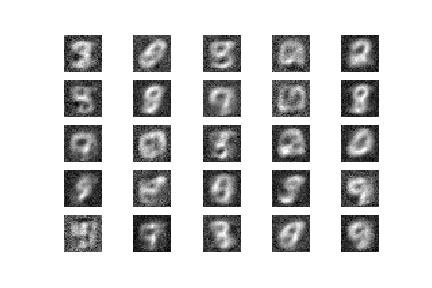

In [25]:
from PIL import Image
Image.open('images/mnist_0.png')